# Pharmaceutical LLM RAG

##### In this notebook we are testing the following models to analyze the performance of answering different pharmaceutical question:
 - Asi mini
 - Llama 3(locally)
 - ChatGPT 3.5

For each model a langchain is built to give the models context of different drugs but we are also testing the models without RAG to analyse the performance.

For testing **Giskard** is used to generate from pdfs questions and answers which are going to be compared against the output of the models mentioned above. Giskard used GPT 3.5 to analyse Asi mini and Llama 3, and GPT 4 to analyse GPT 3.5

Afterwards query translations are used for one of the models(Asi mini) to see how it enhances the performance of the given tasks. The following querry translations methods are used:
- Multi query
- RAG-Fusion
- Decomposition
- Step Back
- HyDE

##### Imports & Variables

In [1]:
import os
import requests
import pandas as pd

from operator import itemgetter
from pathlib import Path

from langchain_openai import OpenAIEmbeddings
from langchain_openai.chat_models import ChatOpenAI
from langchain_ollama import OllamaLLM 
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain.prompts import ChatPromptTemplate
from langchain.load import dumps, loads
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import FewShotChatMessagePromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser

import giskard
from giskard.rag import KnowledgeBase
from giskard.rag import generate_testset
from giskard.rag import evaluate
from giskard.rag import QATestset
from giskard.rag.question_generators import ComplexQuestionsGenerator

from dotenv import load_dotenv
load_dotenv()

ASI_ONE_KEY = os.getenv("ASI_ONE_KEY")

In [2]:
PDF_PATH = "pdfs_manual"
VECTORSTORE_PATH = "./chroma_db_manual"

MODEL = "asi1-mini"
MODEL_LLAMA3 = "llama3"
MODEL_CHATGPT_3_5 = "gpt-3.5-turbo"

SEARCH_KWARGS = 3

### Pre-processing ###

In [3]:
full_documents = []

pdf_folder = Path(PDF_PATH)
pdf_files = list(pdf_folder.glob("*.pdf"))

for filepath in pdf_files:
    try:
        loader = PyPDFLoader(filepath)
        docs = loader.load()
        full_documents.extend(docs)
        print(f"Parsed {filepath} with {len(docs)} chunks.")
    except Exception as e:
        print(f"Error parsing {filepath}: {e}")

Parsed pdfs_manual/doc_87.pdf with 17 chunks.
Parsed pdfs_manual/doc_52.pdf with 22 chunks.
Parsed pdfs_manual/doc_104.pdf with 12 chunks.


KeyboardInterrupt: 

In [4]:
len(full_documents)

NameError: name 'full_documents' is not defined

In [5]:
full_documents[0].page_content

'BISOPROLOL FUMARATE - bisoprolol fumarate tablet \n \nUnichem Pharmaceuticals (USA), Inc.\n----------\nBisoprolol Fumarate Tablets USP\nRx Only\nDESCRIPTION\nBISOPROLOL FUMARATE USP is a synthetic, beta\n-selective (cardioselective)\nadrenoceptor blocking agent. The chemical name for bisoprolol fumarate is (±)-1-[4-[[2-\n(1-Methylethoxy)ethoxy]methyl]phenoxy]-3-[(1-methylethyl)amino]-2-propanol (E)-2-\nbutenedioate (2:1) (salt). It possesses an asymmetric carbon atom in its structure and is\nprovided as a racemic mixture. The S(-) enantiomer is responsible for most of the beta-\nblocking activity. Its molecular formula is (C\nH\nNO\n)\n•C\nH\nO\n and its structure is:\nBisoprolol fumarate has a molecular weight of 766.97. It is a white crystalline powder\nwhich is approximately equally hydrophilic and lipophilic, and is readily soluble in water,\nmethanol, ethanol, and chloroform.\nBISOPROLOL FUMARATE TABLETS USP are available as 5 and 10 mg tablets for oral\nadministration.\nInactive

### Split

In [6]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

splits = text_splitter.split_documents(full_documents)

In [7]:
len(splits)

10249

### Index with Retrieval

In [4]:
### Create vectorstore only if needed
create = False

if create:
    print("Creating vectorstore")
    vectorstore = Chroma.from_documents(documents=splits, 
                                        embedding=OpenAIEmbeddings(model="text-embedding-3-small"),
                                        persist_directory=VECTORSTORE_PATH
    )
    vectorstore.persist()
else:
    print("Using existing vector store")
    embedding_function = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = Chroma(
        persist_directory=VECTORSTORE_PATH,
        embedding_function=embedding_function
    )

Using existing vector store


/tmp/ipykernel_7262/2185640746.py:14: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [5]:
retriever = vectorstore.as_retriever(search_kwargs={"k": SEARCH_KWARGS})

### Models

In [6]:
template = """
    Answer the given question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [7]:
template_rag = """
Answer the question only based on the context below use only the given knowledge from the context do not invent or add details that you were treained. 
If you dont know the answer say that you dont know.

Context: {context}

Question: {question}
"""
prompt_rag = ChatPromptTemplate.from_template(template_rag)

#### Asi One Mini RAG

In [8]:
def call_asi_one(prompt):
    if hasattr(prompt, "to_string"):
        prompt = prompt.to_string()

    url = "https://api.asi1.ai/v1/chat/completions"
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {ASI_ONE_KEY}'
    }
    payload = {
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.2,
        "max_tokens": 1000
    }
    response = requests.post(url, headers=headers, json=payload)
    return response.json().get("choices", [{}])[0].get("message", {}).get("content", "No response")

In [9]:
chain_asi_rag = ({
    "context": itemgetter("question") | vectorstore.as_retriever(),
    "question": itemgetter("question"),
}
| prompt_rag
| call_asi_one
| StrOutputParser()
)

#### Asi One Mini


In [10]:
chain_asi = ({
    "question": itemgetter("question"),
}
| prompt
| call_asi_one
| StrOutputParser()
)

#### Llama 3 RAG


In [16]:
model_llama = OllamaLLM(model=MODEL_LLAMA3)

chain_llama3_rag = (
    {
        "context": itemgetter("question") | vectorstore.as_retriever(),
        "question": itemgetter("question"),
    }
    | prompt_rag
    | model_llama
    | StrOutputParser()
)

#### LLama 3

In [17]:
chain_llama3 = ({
    "question": itemgetter("question"),
}
| prompt
| model_llama
| StrOutputParser()
)

#### Gpt 3.5 RAG

In [28]:
model_gpt_3_5 = ChatOpenAI(model=MODEL_CHATGPT_3_5)

chain_gpt_3_5_rag = (
    {
        "context": itemgetter("question") | vectorstore.as_retriever(),
        "question": itemgetter("question"),
    }
    | prompt_rag
    | model_gpt_3_5
    | StrOutputParser()
)

#### Gpt 3.5

In [29]:
chain_gpt_3_5 = ({
    "question": itemgetter("question"),
}
| prompt
| model_gpt_3_5
| StrOutputParser()
)

#### Gpt 4o RAG

In [34]:
model_gpt_4o = ChatOpenAI(model="gpt-4o")

chain_gpt_4o_rag = (
    {
        "context": itemgetter("question") | vectorstore.as_retriever(),
        "question": itemgetter("question"),
    }
    | prompt_rag
    | model_gpt_4o
    | StrOutputParser()
)

#### Gpt 4o

In [35]:
chain_gpt_4o = ({
    "question": itemgetter("question"),
}
| prompt
| model_gpt_4o
| StrOutputParser()
)

### Testing models manually

In [11]:
def answer_fn(chain, data, test_name):
    print(f"\nProcessing {len(data)} questions through Llama3 RAG...")
    
    model_answers = []
    failed_questions = []

    for index, row in data.iterrows():
        question = row['Question']
        print(f"\nProcessing question {index + 1}/{len(data)}: {question[:80]}...")
            
        try:
            result = chain.invoke({"question": question})
            model_answers.append(result)
            print(f"✓ Answer generated successfully")
            print(f"  Answer preview: {result[:100]}...")
                
        except Exception as e:
            print(f"✗ Error processing question: {e}")
            model_answers.append(f"ERROR: {str(e)}")
            failed_questions.append((index + 1, question, str(e)))

    data[f'{test_name}_rag_model_answer'] = model_answers

    output_filename = f'MedInfo2019-QA-Medications-with-{test_name}-answers.xlsx'
    data.to_excel(output_filename, index=False)

#### Preparint testsets

In [23]:
df = pd.read_excel('MedInfo2019-QA-Medications copy.xlsx')
print(df.head())

                                            Question  \
0                   how does valium affect the brain   
1                           qvar 40mg what is it for   
2           is penicillin in the pill "montelukast?"   
3         can i take metamucil with "ciprofloxacin?"   
4  what does using fluorouracil make your face lo...   

                                              Answer  \
0  Diazepam is a benzodiazepine that exerts anxio...   
1  QVAR is indicated in the maintenance treatment...   
2  What are the ingredients in montelukast sodium...   
3  diarrhea is a common problem caused by antibio...   
4  The most frequent adverse reactions to Fluorou...   

                                                 URL  
0  https://dailymed.nlm.nih.gov/dailymed/getFile....  
1  https://dailymed.nlm.nih.gov/dailymed/getFile....  
2  https://dailymed.nlm.nih.gov/dailymed/getFile....  
3  https://dailymed.nlm.nih.gov/dailymed/getFile....  
4  https://dailymed.nlm.nih.gov/dailymed/getFile...

#### Asi Mini RAG

In [24]:
dfr = df[53:102]

In [25]:
answer_fn(chain_asi_rag, dfr, "asi-mini-rag-53-102")


Processing 49 questions through Llama3 RAG...

Processing question 54/49: how to administer insulin...
✓ Answer generated successfully
  Answer preview: Based on the provided context, here are the steps for administering insulin injections:

1. **Prepar...

Processing question 55/49: what dosage amounts does aripiprazole...
✓ Answer generated successfully
  Answer preview: The context provides the following dosage information for aripiprazole orally disintegrating tablets...

Processing question 56/49: what is in norvasc...
✓ Answer generated successfully
  Answer preview: NORVASC is a type of medicine known as a calcium channel blocker (CCB). It contains amlodipine besyl...

Processing question 57/49: how soon does losartan afffect blood pressure...
✓ Answer generated successfully
  Answer preview: Based on the context provided, the effect of losartan on blood pressure is substantially present wit...

Processing question 58/49: should metoprolol and lexapro be taken together?...
✓ An

/tmp/ipykernel_7262/3968088263.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{test_name}_rag_model_answer'] = model_answers


#### Asi Mini

In [26]:
dfd = df[90:131]

In [27]:
answer_fn(chain_asi, dfd, "asi-mini-91-131")


Processing 41 questions through Llama3 RAG...

Processing question 91/41: how to wean off lamotrigine...
✓ Answer generated successfully
  Answer preview: Weaning off lamotrigine (brand names include Lamictal) should always be done under the guidance of a...

Processing question 92/41: what is amphetamine...
✓ Answer generated successfully
  Answer preview: Amphetamine is a powerful central nervous system (CNS) stimulant belonging to the phenethylamine cla...

Processing question 93/41: what valacyclovir looks like in color shape...
✓ Answer generated successfully
  Answer preview: Valacyclovir is a prescription medication available in tablet form, and its appearance can vary depe...

Processing question 94/41: is 600mg of gabapentin considered a strong dose ? how high in my can it go?...
✓ Answer generated successfully
  Answer preview: Here's a complete answer to your question about gabapentin dosing:

**Is 600mg of gabapentin conside...

Processing question 95/41: motoprolol pill h

/tmp/ipykernel_7262/3968088263.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{test_name}_rag_model_answer'] = model_answers


#### Llama 3 RAG

In [ ]:
answer_fn(chain_llama3_rag, df, "llama3-rag")

#### Llama 3

In [ ]:
answer_fn(chain_llama3, df, "llama3")

#### Gpt 3.5 RAG

In [31]:
answer_fn(chain_gpt_3_5_rag, df, "gpt-3.5-rag")


Processing 131 questions through Llama3 RAG...

Processing question 1/131: how does valium affect the brain...
✓ Answer generated successfully
  Answer preview: Valium is a benzodiazepine and a CNS depressant with potential for abuse and addiction. It may cause...

Processing question 2/131: qvar 40mg what is it for...
✓ Answer generated successfully
  Answer preview: QVAR 40mcg is a medication used for the treatment of asthma in patients 5 years of age and older. It...

Processing question 3/131: is penicillin in the pill "montelukast?"...
✓ Answer generated successfully
  Answer preview: No, penicillin is not mentioned as an ingredient in the pill "montelukast" based on the provided con...

Processing question 4/131: can i take metamucil with "ciprofloxacin?"...
✓ Answer generated successfully
  Answer preview: No, you should avoid taking Metamucil with ciprofloxacin as stated in the document that concurrent a...

Processing question 5/131: what does using fluorouracil make your fac

#### Gpt 3.5

In [32]:
answer_fn(chain_gpt_3_5, df, "gpt-3.5")


Processing 131 questions through Llama3 RAG...

Processing question 1/131: how does valium affect the brain...
✓ Answer generated successfully
  Answer preview: Valium, also known as diazepam, is a type of medication called a benzodiazepine that affects neurotr...

Processing question 2/131: qvar 40mg what is it for...
✓ Answer generated successfully
  Answer preview: Qvar is a medication that contains the active ingredient beclomethasone dipropionate, which is a cor...

Processing question 3/131: is penicillin in the pill "montelukast?"...
✓ Answer generated successfully
  Answer preview: No, penicillin is not in the pill Montelukast. Montelukast is a medication used to treat asthma and ...

Processing question 4/131: can i take metamucil with "ciprofloxacin?"...
✓ Answer generated successfully
  Answer preview: It is generally safe to take Metamucil with ciprofloxacin, as there is no known interaction between ...

Processing question 5/131: what does using fluorouracil make your fac

#### Gpt-4o RAG

In [36]:
answer_fn(chain_gpt_4o_rag, df, "gpt-4o-rag")


Processing 131 questions through Llama3 RAG...

Processing question 1/131: how does valium affect the brain...
✓ Answer generated successfully
  Answer preview: The context does not provide specific information about how Valium affects the brain....

Processing question 2/131: qvar 40mg what is it for...
✓ Answer generated successfully
  Answer preview: QVAR 40 mcg is an inhaled medication used for the treatment of asthma. It is administered via the or...

Processing question 3/131: is penicillin in the pill "montelukast?"...
✓ Answer generated successfully
  Answer preview: No, penicillin is not in the pill "montelukast." The document provides information on the active and...

Processing question 4/131: can i take metamucil with "ciprofloxacin?"...
✓ Answer generated successfully
  Answer preview: The context provided does not mention Metamucil or its interaction with ciprofloxacin. Therefore, I ...

Processing question 5/131: what does using fluorouracil make your face look like...


#### Gpt-4o

In [37]:
answer_fn(chain_gpt_4o, df, "gpt-4o")


Processing 131 questions through Llama3 RAG...

Processing question 1/131: how does valium affect the brain...
✓ Answer generated successfully
  Answer preview: Valium, known generically as diazepam, is a medication belonging to the benzodiazepine class, and it...

Processing question 2/131: qvar 40mg what is it for...
✓ Answer generated successfully
  Answer preview: Qvar is a brand name for a medication whose active ingredient is beclomethasone dipropionate. It is ...

Processing question 3/131: is penicillin in the pill "montelukast?"...
✓ Answer generated successfully
  Answer preview: No, penicillin is not in the pill montelukast. Montelukast is a medication used to manage allergies ...

Processing question 4/131: can i take metamucil with "ciprofloxacin?"...
✓ Answer generated successfully
  Answer preview: It is generally recommended to avoid taking fiber supplements like Metamucil at the same time as cer...

Processing question 5/131: what does using fluorouracil make your fac

/tmp/ipykernel_40090/1442468778.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=models, y=accuracy, palette="viridis")


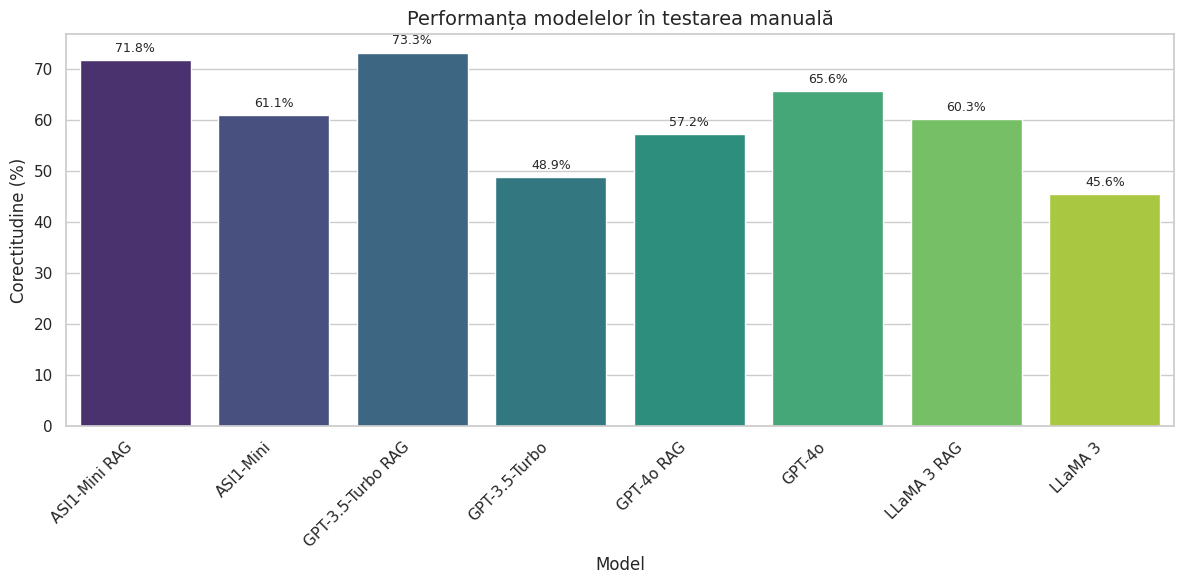

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_accuracy():
    # Modelele și corectitudinea asociată
    models = [
        "ASI1-Mini RAG", "ASI1-Mini",
        "GPT-3.5-Turbo RAG", "GPT-3.5-Turbo",
        "GPT-4o RAG", "GPT-4o",
        "LLaMA 3 RAG", "LLaMA 3"
    ]

    accuracy = [
        71.75, 61.06,
        73.28, 48.85,
        57.25, 65.64,
        60.30, 45.56
    ]

    # Setare stil Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # Creare grafic
    barplot = sns.barplot(x=models, y=accuracy, palette="viridis")

    # Adăugare valori peste fiecare bară
    for i, value in enumerate(accuracy):
        plt.text(i, value + 1, f"{value:.1f}%", ha='center', va='bottom', fontsize=9)

    # Etichete și titlu
    plt.title("Performanța modelelor în testarea manuală", fontsize=14)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Corectitudine (%)", fontsize=12)
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Apelează funcția
plot_model_accuracy()
